<a href="https://colab.research.google.com/github/mhlaghari/Market_basket/blob/main/Market_Basket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Recommendations for India’s Largest Grocery Store’s Mobile App 🛒

🤔 **Situation:** Bigbasket is India's largest online grocery and food store established in 2011 by a group of entrepreneurs Hari Menon, Vipul Parekh, V S Ramesh, V S Sudhakar, and Abhinay Choudhari. In 2016, Bigbasket sold more than 18,000 products and 1,000 brands operating across 12 Indian cities. India is among the top-10 food and grocery markets in the world, with an estimated size of approximately USD 350 billion, and the online (especially mobile) channel is growing fast, especially due to COVID. Note that 30% of Bigbasket customers place orders through smart phones.

🥴 **Complication:** Bigbasket is trying to solve a problem frequently encountered by customers of online grocery stores. Unlike other e-commerce companies such as Amazon, Bigbasket customers place orders for several products in a single order, sometimes as high as 80 products in one order depending on their purchase frequency. It is common that customers forget to order few grocery items which may result either in placing additional orders or customers purchasing those products from neighborhood stores resulting in a financial loss to online grocery stores.

🔑 **Key question:** Can we use analytics to create a smart basket enabled by a "Did you forget?" feature that would identify the items the customer may have forgotten to order.

💡 **Solution approach:** Use association rules mining to find products that are co- purchased, and use this to recommend products at the time of purchase/just before check-out.

**Discussion questions from analysis:**
  1. Which of the many rules should we use? How to decide this?
  2. How will these rules be integrated into the app?
  3. How will we know this creates business value?



## Apriori Overview
Association Rule Learning is an approach that discovers the strength of relationships between different data-points. It is commonly utilised to understand which products are frequently (or infrequently) purchased together.

In a business sense this can provide some really interesting, and useful information that can help optimise:

* Product Arrangement/Placement (making the customer journey more efficient)
* Product Recommendations (customers who purchased product A also purchased product B)
* Bundled Discounts (which products should/should not be put together)
One powerful, intuitive, and commonly used algorithm for Association Rule Learning is Apriori.

In Apriori there are four key metrics, namely:

* Support
* Confidence
* Expected Confidence
* Lift

Each of these metrics help us understand items, and their relationship with other items in their own way.



### Support
Support is extremely intuitive, it simply tells us the percentage of all transactions that contain both Item A and Item B. To calculate this we’d just count up the transactions that include both items, and divide this by the total number of transactions.

You can think of Support as a baseline metric that helps us understand how common or popular this particular pair of items is.



### Confidence
Confidence takes us a little bit further than Support, and looks more explcitly at the relationship between the two items.

It asks “of all transactions that included item A, what proportion also included item B?”

In other words, here we are counting up the number of transactions that contained both items A and B and then rather than dividing by all transactions like we did for Support, we instead divide this by the total number of transactions that contained item A.

A high score for Confidence can mean a strong product relationship - but not always! When one of the items is very popular we can get an inflated score. To help us regulate this, we can look at two further metrics, Expected Confidence and Lift!



### Expected Confidence
Expected Confidence is quite simple, it is the percentage of all transactions that contained item B.

This is important as it provides indication of what the Confidence would be if there were no relationship between the items. We can use Expected Confidence, along with Confidence to calculate our final (and most powerful) metric - Lift!



### Lift
Lift is the factor by which the Confidence, exceeds the Expected Confidence. In other words, Lift tells us how likely item B is purchased when item A is purchased, while controlling for how popular item B is.

We calculate Lift by dividing Confidence by Expected Confidence.

A Lift score greater than 1 indicates that items A & B appear together more often than expected, and conversely a Lift score less then 1 indicates that items A & B appear together less often than expected.



### In Practice
While above we’re just discussing two products (Item A & Item B) - in reality this score would be calculated between all pairs of products, and we could then sort these by Lift score (for example) and see exactly what the strongest or weakest relationships were - and this information would guide our decisions regarding product layout, recommendations for customers, or promotions.



### An Important Consideration
Something to consider when assessing the results of Apriori is that, Item/Product relationships that have a high Lift score but also have a low Support score should be interpreted with caution!

In other words, if we sorted all Item relationships by descending Lift score, the one that comes out on top might initially seem very impressive and it may appear that there is a very strong relationship between the two items. Always take into account the Support metric - it could be that this relationship is only taking place by chance due to the rarity of the item set.



In [ ]:
# !pip install --upgrade ipykernel

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
#!pip install apyori
# from apyori import apriori

## 1. Data Loading



In [72]:
# Data loading and seeing the top 5 samples of our data
transactions = pd.read_excel('/content/BigBasket Data IMB575-XLS-ENG (1).xlsx',
sheet_name='POS DATA')
transactions.head(5)

,Member,Order,SKU,Created On,Description
0,M09736,6468572,34993740,22-09-2014 22:45,Other Sauces
1,M09736,6468572,15669800,22-09-2014 22:45,Cashews
2,M09736,6468572,34989501,22-09-2014 22:45,Other Dals
3,M09736,6468572,7572303,22-09-2014 22:45,Namkeen
4,M09736,6468572,15669856,22-09-2014 22:45,Sugar


In [47]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62141 entries, 0 to 62140
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Member       62141 non-null  object
 1   Order        62141 non-null  int64 
 2   SKU          62141 non-null  int64 
 3   Created On   62141 non-null  object
 4   Description  62141 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.4+ MB


In [49]:
# Converting created on to datetype
transactions['date'] = pd.to_datetime(transactions['Created On'])
transactions.head(5)

,Member,Order,SKU,Created On,Description,date
0,M09736,6468572,34993740,22-09-2014 22:45,Other Sauces,2014-09-22 22:45:00
1,M09736,6468572,15669800,22-09-2014 22:45,Cashews,2014-09-22 22:45:00
2,M09736,6468572,34989501,22-09-2014 22:45,Other Dals,2014-09-22 22:45:00
3,M09736,6468572,7572303,22-09-2014 22:45,Namkeen,2014-09-22 22:45:00
4,M09736,6468572,15669856,22-09-2014 22:45,Sugar,2014-09-22 22:45:00


In [40]:
# Check for na's
transactions.isna().sum()

Member         0
Order          0
SKU            0
Created On     0
Description    0
dtype: int64

## 2. Quick EDA

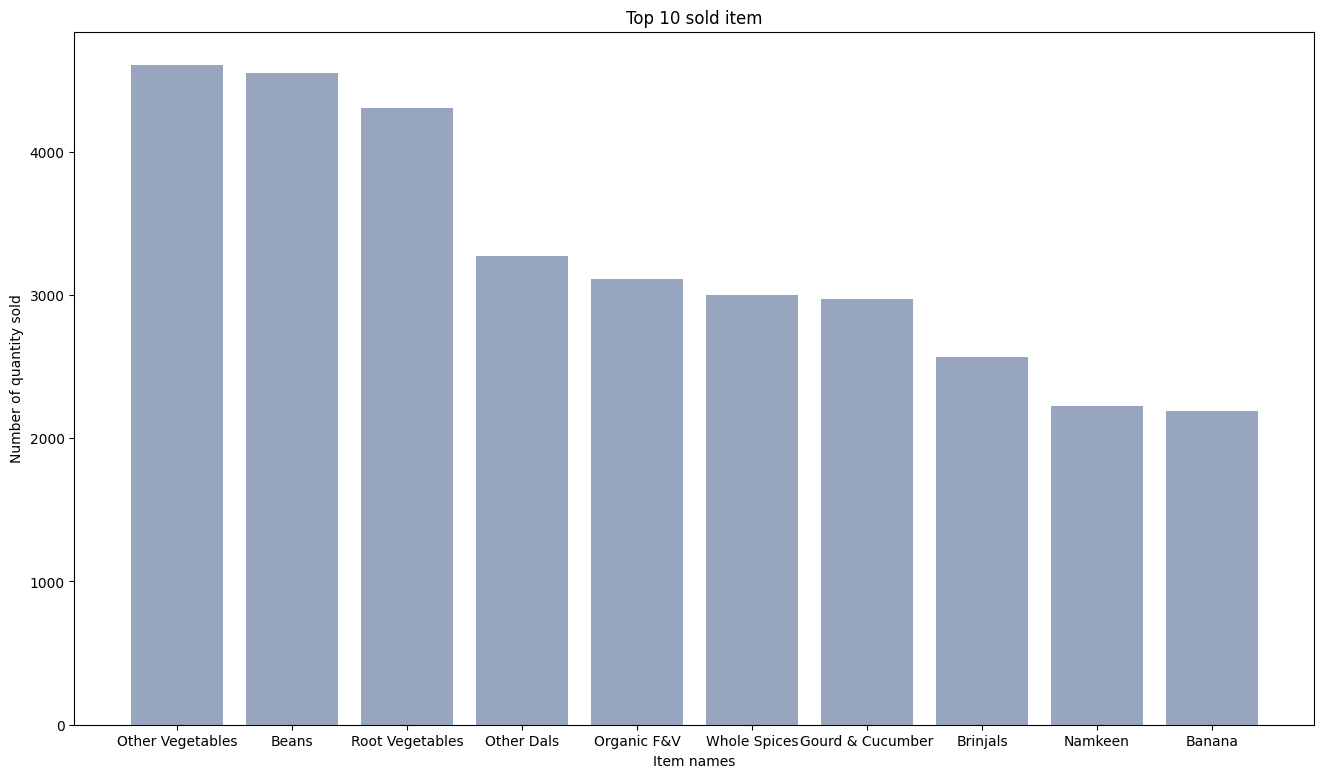

In [50]:
# Lets check the item distribution
item_distribution = transactions.groupby(by = 'Description').size().reset_index(name='Frequency').sort_values(by='Frequency', ascending=False).head(10)

bars = item_distribution['Description']
height = item_distribution['Frequency']
x_pos = np.arange(len(bars))

plt.figure(figsize=(16,9))
plt.bar(x_pos, height, color=(0.2,0.3,0.5,0.5))

plt.title('Top 10 sold item')
plt.xlabel('Item names')
plt.ylabel('Number of quantity sold')

plt.xticks(x_pos, bars)

plt.show()

In [51]:
df_date = transactions.set_index(['date'])
df_date.head(2)

,Member,Order,SKU,Created On,Description
date,,,,,
2014-09-22 22:45:00,M09736,6468572,34993740,22-09-2014 22:45,Other Sauces
2014-09-22 22:45:00,M09736,6468572,15669800,22-09-2014 22:45,Cashews


[Text(0.5, 0, 'date'), Text(0, 0.5, 'number of items sold')]

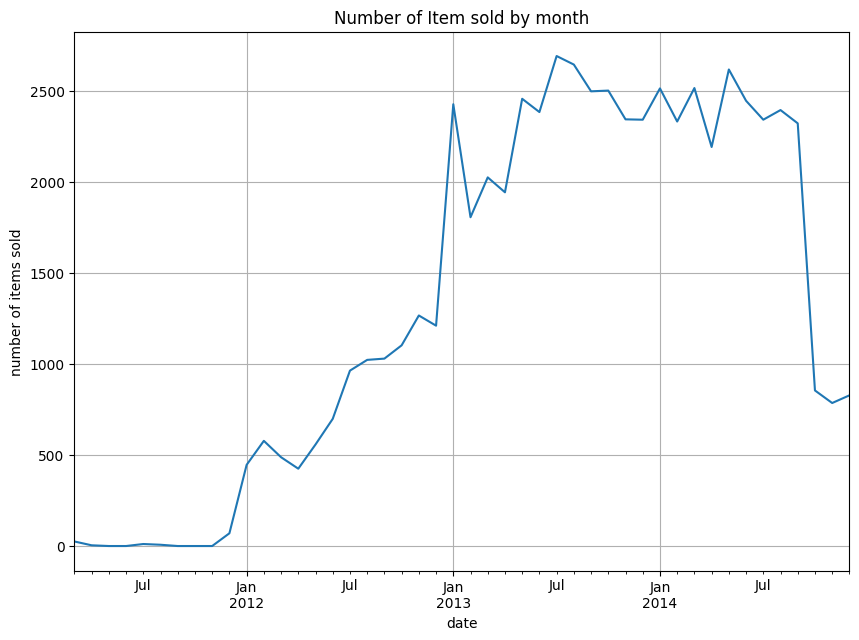

In [52]:
df_date.resample("M")['Description'].count().plot(figsize=(10,7), grid=True, title='Number of Item sold by month').set(xlabel="date", ylabel='number of items sold')

## 3. Data preprocessing

In this stage, I will preprocess the data and remove duplicates

In [80]:
# Group by 'id' and aggregate the 'description' column
grouped_df = transactions.groupby('Order')['Description'].agg(','.join).reset_index()
grouped_df.head(5)

,Order,Description
0,6422558,"Boiled Rice,Other Rice Products,Mosquito Repel..."
1,6422636,"Sunflower Oils,Brinjals,Root Vegetables,Other ..."
2,6423338,"Beans,Banana,Snacky Nuts,Cashews,Sooji & Rava,..."
3,6423534,"Facial Tissues,Organic F&V,Cakes,Cookies"
4,6423959,"Other Dals,Sunflower Oils,Namkeen,Other Sweets"


In [81]:
data = list(grouped_df["Description"].apply(lambda x:x.split(",") ))
data[:5]

[['Boiled Rice',
  'Other Rice Products',
  'Mosquito Repellent',
  'Sugar',
  'Health Drinks',
  'Root Vegetables',
  'Raw Rice',
  'Root Vegetables',
  'Health Drinks'],
 ['Sunflower Oils',
  'Brinjals',
  'Root Vegetables',
  'Other Vegetables',
  'Whole Spices',
  'Gourd & Cucumber',
  'Beans',
  'Toor Dal',
  'Other Sweets',
  'Avalakki / Poha',
  'Beans'],
 ['Beans',
  'Banana',
  'Snacky Nuts',
  'Cashews',
  'Sooji & Rava',
  'Raw Rice',
  'Toor Dal',
  'Yogurt & Lassi',
  'Yogurt & Lassi',
  'Almonds',
  'Yogurt & Lassi',
  'Chips'],
 ['Facial Tissues', 'Organic F&V', 'Cakes', 'Cookies'],
 ['Other Dals', 'Sunflower Oils', 'Namkeen', 'Other Sweets']]

In [82]:
from mlxtend.preprocessing import TransactionEncoder
a = TransactionEncoder()
a_data = a.fit(data).transform(data)
df = pd.DataFrame(a_data,columns=a.columns_)
df = df.replace({True: 1, False: 0})
df

,Cookies & Rusk,Foam & Gels,Glue & Tape,Marie & Milk Biscuits,Peelers & Scrapers,0_x000D_\n7831582,0_x000D_\n7831689,0_x000D_\n7832047,0_x000D_\n7832360,2,...,Wafers,Washing Bars,Whole Grains,Whole Spices,Womens Deo,Yogurt & Lassi,cfls,channa-dal,cheese,chewing-gum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 4. Training

In [93]:
frequent_items = apriori(df, min_support = 0.05, use_colnames = True, verbose = 1)
frequent_items

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Processing 24 combinations | Sampling itemset size 8


,support,itemsets
0,0.008346,( Foam & Gels)
1,0.048766,( Marie & Milk Biscuits)
2,0.008346,(Agarbatti)
3,0.062001,(Almonds)
4,0.016096,(Aluminium Foil & Cling Wrap)
...,...,...
6321,0.005365,"(Sooji & Rava, Sugar, Urad Dal, Whole Spices, ..."
6322,0.005365,"(Other Vegetables, Brinjals, Beans, Gourd & Cu..."
6323,0.005008,"(Other Vegetables, Brinjals, Beans, Gourd & Cu..."
6324,0.005246,"(Other Vegetables, Beans, Whole Spices, Gourd ..."


In [94]:
#Let's view our interpretation values using the Associan rule function.
rules = association_rules(frequent_items, metric = "lift", min_threshold = 1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( Foam & Gels),(Shaving Cream),0.008346,0.008346,0.008346,1.000000,119.814286,0.008277,inf,1.000000
1,(Shaving Cream),( Foam & Gels),0.008346,0.008346,0.008346,1.000000,119.814286,0.008277,inf,1.000000
2,(Avalakki / Poha),( Marie & Milk Biscuits),0.077024,0.048766,0.006319,0.082043,1.682390,0.002563,1.036252,0.439456
3,( Marie & Milk Biscuits),(Avalakki / Poha),0.048766,0.077024,0.006319,0.129584,1.682390,0.002563,1.060385,0.426401
4,(Banana),( Marie & Milk Biscuits),0.260284,0.048766,0.015858,0.060925,1.249342,0.003165,1.012948,0.269804
...,...,...,...,...,...,...,...,...,...,...
81833,(Whole Spices),"(Other Vegetables, Beans, Moong Dal, Toor Dal,...",0.203768,0.008346,0.005127,0.025161,3.014637,0.003426,1.017249,0.839309
81834,(Moong Dal),"(Other Vegetables, Beans, Whole Spices, Toor D...",0.134852,0.007392,0.005127,0.038019,5.143051,0.004130,1.031838,0.931127
81835,(Toor Dal),"(Other Vegetables, Beans, Whole Spices, Moong ...",0.152259,0.008227,0.005127,0.033673,4.092937,0.003874,1.026332,0.891401
81836,(Other Dals),"(Other Vegetables, Beans, Whole Spices, Moong ...",0.232741,0.006081,0.005127,0.022029,3.622639,0.003712,1.016307,0.943564


In [88]:
df['Beans'].sum()

3347

In [89]:
df['Banana'].sum()

2183

In [95]:
rules = rules.sort_values(by='lift', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( Foam & Gels),(Shaving Cream),0.008346,0.008346,0.008346,1.000000,119.814286,0.008277,inf,1.000000
1,(Shaving Cream),( Foam & Gels),0.008346,0.008346,0.008346,1.000000,119.814286,0.008277,inf,1.000000
38460,"(Organic F&V, Sugar & Jaggery)","(Organic Salt, Organic Dals & Pulses)",0.009181,0.009181,0.005365,0.584416,63.655760,0.005281,2.384159,0.993411
38465,"(Organic Salt, Organic Dals & Pulses)","(Organic F&V, Sugar & Jaggery)",0.009181,0.009181,0.005365,0.584416,63.655760,0.005281,2.384159,0.993411
38464,"(Sugar & Jaggery, Organic Dals & Pulses)","(Organic F&V, Organic Salt)",0.009181,0.009181,0.005365,0.584416,63.655760,0.005281,2.384159,0.993411
...,...,...,...,...,...,...,...,...,...,...
1885,(Gourd & Cucumber),"(Almonds, Other Dals)",0.300346,0.021819,0.006558,0.021834,1.000668,0.000004,1.000015,0.000954
24111,(Whole Spices),"(Beans, Gourd & Cucumber, Organic F&V)",0.203768,0.024562,0.005008,0.024576,1.000568,0.000003,1.000014,0.000713
24104,"(Beans, Gourd & Cucumber, Organic F&V)",(Whole Spices),0.024562,0.203768,0.005008,0.203883,1.000568,0.000003,1.000145,0.000582
677,(Exotic Vegetables),(Sugar),0.121855,0.159413,0.019435,0.159491,1.000488,0.000009,1.000093,0.000556
